In [1]:
%matplotlib notebook
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import qcodes as qc
from qcodes.instrument_drivers.ZI.ZIUHFLI import ZIUHFLI

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

# Prerequisites

It is necessary to download and install the ZI Lab One software. Additionally, both the data server and the web server must run, and a connection to the instrument must be instantiated (this can be done via the web interface).

In [2]:
# Instantiate the QCoDeS instrument
zi = ZIUHFLI('ZIUHFLI', 'dev2235')

# Basic Usage of the ZI UHF-LI

Most of the "front panel" (i.e. the Web UI) `Lock-In` and `signal input` settings are available as parameters.

In [7]:
zi.oscillator2_freq.set(752.1e3)
print('Oscillator 2 has frequency: {:.0f} Hz'.format(zi.oscillator2_freq.get()))
zi.signal_input1_range(1)
zi.signal_input1_scaling(1)

Oscillator 2 has frequency: 752100 Hz


Each demodulator has several settings...

In [8]:
print('Available demodulator settings:\n')
for param in [p for p in zi.parameters if 'demod1' in p]:
    print('  {}, {} ({})'.format(param, zi.parameters[param].label, zi.parameters[param].unit))

Available demodulator settings:

  demod1_harmonic, Reference frequency multiplication factor ()
  demod1_samplerate, Sample rate (Sa/s)
  demod1_trigger, Trigger ()
  demod1_streaming, Data streaming ()
  demod1_signalin, Signal input ()
  demod1_order, Filter order ()
  demod1_phaseshift, Phase shift (degrees)
  demod1_timeconstant, Filter time constant (s)
  demod1_sinc, Sinc filter ()


# Using the sweeper

The sweeper settings are configured via a bunch of parameters, all named `sweeper_XXX`.
This configures the x-axis of the sweep as well as the sweep acquisition settings. To learn more about what a certain parameter does, it is sometimes helpful to print its `__doc__` attribute.

Which signals are **returned** by the sweeper is controlled by adding (removing) signals to (from) the sweep.

The sweep settings can be displayed with the `print_sweeper_settings` command.

Before the sweep can be performed, it must be built. 
This is done with the Sweep parameter, which is the parameter holding the sweep data.
Note that building the sweep may change some of the time constants, and in particular change the sweep time. In case of doubt, re-run `print_sweeper_settings`.

In [64]:
# Set up a sweep sweeping an internal oscillator frequency from 1 MHz to 5 MHz
# We want the sweeper to sweep linearly over 200 points
zi.sweeper_param('Osc 1 Frequency')
zi.sweeper_xmapping('lin')
zi.sweeper_start(1e6)
zi.sweeper_stop(10e6)
zi.sweeper_samplecount(100)
zi.sweeper_BWmode('fixed')
zi.sweeper_BW(250)
zi.sweeper_order(4)

In [65]:
# I wonder what the sweeper BWmode does...
print(zi.sweeper_BWmode.__doc__)


                                     For each sweep point, the demodulator
                                     filter bandwidth (time constant) may
                                     be either set automatically, be the
                                     current demodulator bandwidth or be
                                     a fixed number; the sweeper_BW
                                     parameter.
                                     

Parameter class:

* `name` sweeper_BWmode
* `label` Sweeper bandwidth control mode
* `unit` 
* `vals` <Enum: {'auto', 'fixed', 'current'}>


In [66]:
# Add three signals to the sweep, all measured on demodulator 1
zi.add_signal_to_sweeper(1, 'Xrms')
zi.add_signal_to_sweeper(1, 'Yrms')
zi.add_signal_to_sweeper(1, 'Rrms')

In [67]:
# Make sure that demodulator 1 is measuring what and as it should
zi.demod1_trigger('Continuous')
zi.demod1_signalin('Sig In 1')

In [68]:
# I wonder what kind of sweep we have made now...
zi.print_sweeper_settings()

ACQUISITION
    Sweeper bandwidth control mode: fixed ()
    Fixed bandwidth sweeper bandwidth (NEP): 50.0 ()
    Sweeper filter order: 1 ()
    Minimal no. of samples to average at each sweep point: 25 ()
    Minimal averaging time: 0.1 (s)
    Minimal settling time for the sweeper: 1e-06 (s)
    Sweep filter settling time: 4.605170185988091 (dim. less.)
HORISONTAL
    Start value of the sweep: 1000000.0
    Stop value of the sweep: 10000000.0
    Units of sweep x-axis: Hz
    Length of the sweep (pts): 25
    Parameter to sweep (sweep x-axis): Osc 1 Frequency
    Sweep mode: Sequential
    Sweep timeout: 600
VERTICAL
    Signal 1: Demodulator 1: Xrms
    Signal 2: Demodulator 1: Yrms
    Signal 3: Demodulator 1: Rrms
DEMODULATORS
    Demodulator 1: Filter time constant: 0.000810 (s)
    Demodulator 1: Filter order: 3.000000 ()
    Demodulator 1: Sample rate: 1716.613770 (Sa/s)
META
    Expected sweep time: 0.9 (s)
    Sweep timeout: 600 (s)
    Sweep built and ready to execute: False

In [69]:
# Gee, that looks good! Note the last line, the sweep is NOT ready to execute.
zi.Sweep.build_sweep()
# Now it is!
zi.print_sweeper_settings()

ACQUISITION
    Sweeper bandwidth control mode: fixed ()
    Fixed bandwidth sweeper bandwidth (NEP): 250.0 ()
    Sweeper filter order: 4 ()
    Minimal no. of samples to average at each sweep point: 25 ()
    Minimal averaging time: 0.1 (s)
    Minimal settling time for the sweeper: 1e-06 (s)
    Sweep filter settling time: 9.998049677807453 (dim. less.)
HORISONTAL
    Start value of the sweep: 1000000.0
    Stop value of the sweep: 10000000.0
    Units of sweep x-axis: Hz
    Length of the sweep (pts): 100
    Parameter to sweep (sweep x-axis): Osc 1 Frequency
    Sweep mode: Sequential
    Sweep timeout: 600
VERTICAL
    Signal 1: Demodulator 1: Xrms
    Signal 2: Demodulator 1: Yrms
    Signal 3: Demodulator 1: Rrms
DEMODULATORS
    Demodulator 1: Filter time constant: 0.000810 (s)
    Demodulator 1: Filter order: 3.000000 ()
    Demodulator 1: Sample rate: 1716.613770 (Sa/s)
META
    Expected sweep time: 1.8 (s)
    Sweep timeout: 600 (s)
    Sweep built and ready to execute: Tru

In [70]:
# We can now execute the sweeper by simply invoking Sweep.get
# This returns a tuple with the signals we asked for
(X, Y, R) = zi.Sweep.get()

In [71]:
# This we may manually plot. 

<IPython.core.display.Javascript object>


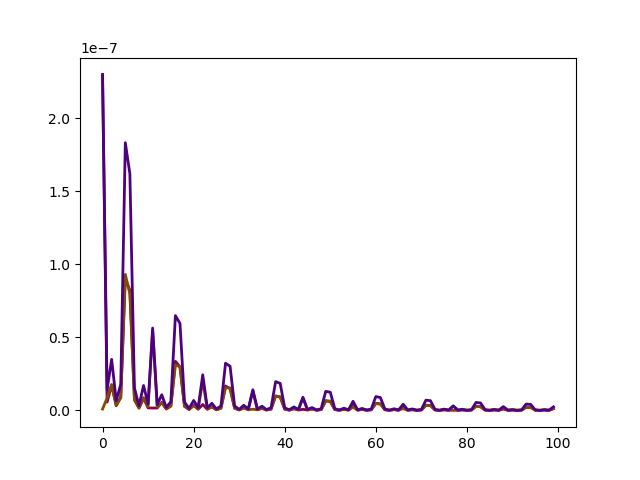

In [72]:
plt.figure()
plt.plot(X, lw=2, color=(0.5, 0, 0.3))
plt.plot(Y, lw=2, color=(0.5, 0.3, 0))
plt.plot(R, lw=2, color=(0.3, 0, 0.5))

# Using the scope

Check it. The scope. Many of the scope parameters depend on each other.

In [19]:
zi.scope_samplingrate('113 MHz')
print(zi.scope_samplingrate())
zi.scope_samplingrate('28.1 MHz')

113 MHz


In [18]:
zi.oscillator1_freq(10e6)
print(zi.oscillator1_freq())
zi.oscillator1_freq(5e6)

4999999.999997584


In [29]:
zi.scope_samplingrate()

'28.1 MHz'

In [30]:
# Sampling rate, trace length, and trace duration all depend on each other
zi.scope_samplingrate('56.2 MHz')  # starting value for example

(SR, length, dur) = (zi.scope_samplingrate(), zi.scope_length(), zi.scope_duration())
print('Current scope settings: SR: {}, Length: {:d}, duration: {:.6f} ({})'.format(SR, int(length), dur, zi.scope_duration.unit))

# Now we change the 
zi.scope_duration(10e-3)
# The driver has now updated the length behind the scenes, so that the internal QCoDeS length matches what a new
# query will return
print('The length is {}, {}'.format(zi.scope_length.get_latest(), zi.scope_length.get()))

# Similarly if we change the number of points to half of the current value
oldN = zi.scope_length.get_latest()
zi.scope_length(int(oldN/2))
print('The duration is {}, {} and the length is {}'.format(zi.scope_duration.get_latest(),
                                                           zi.scope_duration.get(),
                                                           zi.scope_length.get()))

# Finally, note that changing the sampling rate does not change the length, but the duration
zi.scope_samplingrate('28.1 MHz')
print('Finally, length: {} points, duration : {} (s)'.format(zi.scope_length.get_latest(), zi.scope_duration.get_latest()))

Current scope settings: SR: 28.1 MHz, Length: 281000, duration: 0.010000 (s)
The length is 562000, 281000
The duration is 0.0025, 0.0025 and the length is 140500
Finally, length: 140500 points, duration : 0.005 (s)


In [17]:

zi.scope_duration()

0.00125

In [37]:

zi.scope_duration(300e-6)
print(zi.scope_length())

540000.0


In [7]:
zi.scope_trig_holdoffmode()

's'

In [32]:
exdata = poll_like_the_example()
print(len(exdata['/dev2235/scopes/0/wave']))

40


In [171]:
def poll_scope_data(length, trig_lvl, segments=1):

    device = zi.device


    # set the trace length
    zi.scope_duration(length)

    # 'enable' : enable the scope.
    zi.daq.setInt('/%s/scopes/0/enable' % device, 1)
    # Subscribe to the scope's data.

    zi.daq.setInt('/dev2235/scopes/0/segments/enable', 1)
    zi.scope_segments(segments)

    zi.daq.setInt('/%s/scopes/0/trigenable' % device, 1)
    zi.daq.setDouble('/%s/scopes/0/triglevel' % device, trig_lvl)

    deadtime = zi.scope_trig_holdoffseconds()

    # poll_length = (length+deadtime)*segments  # (s)
    poll_timeout = (length+deadtime)*2100  # (ms), 1100 instead of 1000 to allow for small delays

    zi.daq.subscribe('/%s/scopes/0/wave' % device)
    zi.daq.sync()

    # data = zi.daq.poll(poll_length, poll_timeout, 0, True)
    data = []
    for polls in range(segments):
        try:
            data.append(zi.daq.pollEvent(int(poll_timeout))[0])  # polls a single buffer. What constitutes a buffer?
        except IndexError:
            print('Scope not responding')
    # 'enable' : disable the scope.
    zi.daq.setInt('/%s/scopes/0/enable' % device, 0)
    # unsubscribe scope's data.
    zi.daq.unsubscribe('*')

    zi.daq.sync()
    return data

In [172]:
def dataparser(rawdata):
    """
    Parses the output of the poll_scope_data
    
    Returns a scaled np.array
    """
    data = rawdata['/{}/scopes/0/wave'.format(zi.device)][0]
    wave = data['wave']*data['channelscaling'][0]  # 0: first of up to four waves. Our UHF only supports two.
    N = data['totalsamples']
    assert N == len(wave), 'Wait a minute, something is wrong here'
    dt = data['dt']
    time = np.linspace(0, dt*N, N)

    return time, wave
    


In [176]:
data = poll_scope_data(5e-3, 0.2, segments=5)
print('Polled data from ZI scope. Got {} segment(s)'.format(len(data)))
for wave in data:
    print('Segment number {}. Error flag: {}'.format(wave['segmentnumber'], wave['flags']))

Polled data from ZI scope. Got 5 segment(s)
Segment number 0. Error flag: 0
Segment number 0. Error flag: 1
Segment number 2. Error flag: 0
Segment number 3. Error flag: 0
Segment number 4. Error flag: 0


In [128]:
data

[[{'blockmarker': 1,
   'blocknumber': 0,
   'channelbwlimit': array([1, 0, 0, 0], dtype=int8),
   'channelenable': array([1, 0, 0, 0], dtype=int8),
   'channelinput': array([1, 0, 0, 0], dtype=int8),
   'channelmath': array([0, 0, 0, 0], dtype=int8),
   'channeloffset': array([ 0.,  0.,  0.,  0.]),
   'channelscaling': array([  1.22070314e-05,   0.00000000e+00,   0.00000000e+00,
            0.00000000e+00], dtype=float32),
   'datatransfermode': 0,
   'dt': 1.1377777777777777e-06,
   'flags': 0,
   'sampleformat': 4,
   'segmentnumber': 1,
   'sequencenumber': 78763,
   'timestamp': 160035165608055,
   'totalsamples': 4400,
   'triggerenable': 1,
   'triggerinput': 1,
   'triggertimestamp': 160035156687777,
   'wave': array([[11648],
          [11744],
          [11840],
          ..., 
          [  576],
          [  576],
          [  560]], dtype=int16)}],
 [{'blockmarker': 1,
   'blocknumber': 0,
   'channelbwlimit': array([1, 0, 0, 0], dtype=int8),
   'channelenable': array([1, 0

This is scope setter. Received 5
This is scope setter. Trying to setInt with time, 5


In [91]:
[][0]

IndexError: list index out of range

In [66]:
data

{'/dev2235/scopes/0/wave': [{'blockmarker': 1,
   'blocknumber': 0,
   'channelbwlimit': array([1, 0, 0, 0], dtype=int8),
   'channelenable': array([1, 0, 0, 0], dtype=int8),
   'channelinput': array([1, 0, 0, 0], dtype=int8),
   'channelmath': array([0, 0, 0, 0], dtype=int8),
   'channeloffset': array([ 0.,  0.,  0.,  0.]),
   'channelscaling': array([  1.22070314e-05,   0.00000000e+00,   0.00000000e+00,
            0.00000000e+00], dtype=float32),
   'datatransfermode': 0,
   'dt': 8.888888888888889e-09,
   'flags': 0,
   'sampleformat': 4,
   'segmentnumber': 2,
   'sequencenumber': 8988,
   'timestamp': 55424282852019,
   'totalsamples': 562500,
   'triggerenable': 1,
   'triggerinput': 1,
   'triggertimestamp': 55424273942100,
   'wave': array([[11648],
          [11712],
          [11680],
          ..., 
          [  560],
          [  592],
          [  560]], dtype=int16)},
  {'blockmarker': 1,
   'blocknumber': 0,
   'channelbwlimit': array([1, 0, 0, 0], dtype=int8),
   'chan

<IPython.core.display.Javascript object>


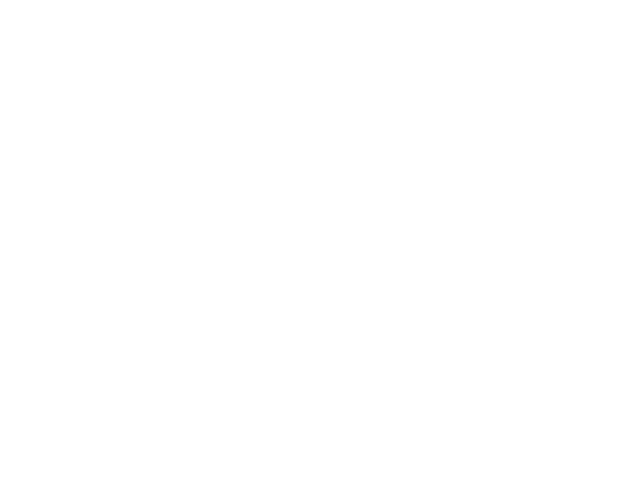

AssertionError: Wait a minute, something is wrong here

In [29]:
plt.figure()
time, wave = dataparser(data)
plt.plot(time, wave)
print(wave[0], len(wave))

In [57]:
zi.close()